# Tutorial for SRLR
This notebook serves as a tutorial for "Sketched Ridgeless Linear Regression: The Role of Downsampling". Absolutely, replication of the graphs in the manuscript is a critical part of this tutorial. The purpose of this tutorial is not just to help you understand the theoretical contributions made by the authors, but also to provide practical insights into the research. Therefore, we'll ensure we follow a hands-on approach where we'll code and replicate most of the graphs from the paper.


We'll start with a brief overview of the key concepts from the paper: ridgeless linear regression and sketched ridgeless linear regression. Then, we'll move onto the practical section, where we will use Python, and specifically libraries such as NumPy for numerical operations, pandas for data handling, and matplotlib and seaborn for visualization, to replicate the findings of the paper.

In [1]:
from SRLR import simulation, estimators, datasets, asymptotics, utils
import numpy as np

# 1. Ridgeless least square estimator

This paper focuses on the linear regression problem. We assume that we have collected a set of independent and identically distributed (i.i.d.) data points following the model:
$$
y_i=\beta^{\top} x_i+\varepsilon_i, i=1, \cdots, n,
$$
where $y_i \in \mathbb{R}$ represents the label of the $i$-th observation, $\beta \in \mathbb{R}^p$ is the unknown random regression coefficient vector, $\mathbb{R}^p \ni x_i \sim x \sim P_x$ is the $p$-dimensional feature vector of the $i$-th observation, with $P_x$ denoting a probability distribution on $\mathbb{R}^p$ having mean $\mathbb{E}(x)=0$ and covariance $\operatorname{cov}(x)=\Sigma$. The $i$-th random noise term $\mathbb{R} \ni \varepsilon_i \sim \varepsilon \sim P_{\varepsilon}$ is independent of $x_i$, with $P_{\varepsilon}$ being a probability distribution on $\mathbb{R}$ having mean $\mathbb{E}(\varepsilon)=0$ and variance $\operatorname{var}(\varepsilon)=\sigma^2$. In matrix form, the model can be expressed as:
$$
Y=X \beta+E
$$
where $X=\left(x_1, \cdots, x_n\right)^{\top} \in \mathbb{R}^{n \times p}, Y=\left(y_1, \cdots, y_n\right)^{\top} \in$ $\mathbb{R}^n$, and $E=\left(\varepsilon_1, \cdots, \varepsilon_n\right)^{\top} \in \mathbb{R}^n$.

We consider the following ridgeless least square estimator
$$
\widehat{\beta}:=\left(X^{\mathrm{T}} X\right)^{+} X^{\mathrm{T}} Y=\lim _{\lambda \rightarrow 0^{+}}\left(X^{\mathrm{T}} X+n \lambda I_p\right)^{-1} X^{\mathrm{T}} Y,
$$

In [2]:
ridgeless = estimators.RidgelessLinearRegressor()

To generate the data with isotropic features and fit the estimator, 
- Assumption 2.2, $\beta \sim \mathcal{N}_p\left(0, \frac{\alpha^2}{p} I_p\right)$, where $||\beta||^2_2 \to \alpha^2$, independent of the data matrix $X$, noise $\epsilon$, sketching matrix $S$
- Assumption 2.1, for $i = 1, \dots, n$, $x_i = \Sigma^{1/2} z_i$ where $z_i$ iid components with mean 0 and variance 1 and finite 4-th moment; $\epsilon \perp X$, $E[\epsilon]=0, Var(\epsilon)=\sigma^2$



In [3]:
n_train = 400
n_features = 200
alpha = 10
sigma = 5
seed = 12344321
n_test = 100
x, y, beta = datasets.gen_train_dat(n_train, n_features, alpha, sigma, seed)

In [4]:
est = ridgeless.fit(x, y)
x_oos, y_oos = datasets.gen_test_dat(n_test, n_features, beta, sigma, seed)
print("The out-of-sample predictionr risk is: ", np.mean((np.matmul(x_oos, est.beta) - np.matmul(x_oos, beta))**2))

The out-of-sample predictionr risk is:  22.680036941837603


The same results can be obtained by calling the following function:

In [5]:
ridgeless = estimators.RidgelessLinearRegressor()
mse = simulation.simulate(ridgeless, n_train, n_features, alpha, sigma, seed, n_test)
print("The out-of-sample predictionr risk is: ", mse)

The out-of-sample predictionr risk is:  22.680036941837603


## Parallel simulation

To run the simulation with different seeds many times, we use `parallel_simulate_phi()`

In [6]:
n_train = 400
n_features = 200
n_test = 100

alpha = 10
sigma = 5
seed = 12344321
n_sim = 500

n_pts = 20                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 100          # number of points in the graph for visualizing theoretical results (line)

In [ ]:
from SRLR import simulation
mse_emp = simulation.parallel_simulate_phi(ridgeless, n_train, n_sim, alpha, sigma, seed, n_test, n_pts)

In [ ]:
mse_asy = asymptotics.parallel_asy_phi(n_train, alpha, sigma, n_pts_asymp, sketching=False)

## Save the results

In [ ]:
from SRLR import utils
utils.save_results(n_train, n_sim, n_pts, n_pts_asymp, alpha, sigma, seed, mse_emp, mse_asy, fix_phi=True, save_path="../result/ridgeless_new/")

## Plotting

In [7]:
files = ['ridgeless/SNR1.0_nsim500.json', \
        'ridgeless/SNR2.0_nsim500.json', \
        'ridgeless/SNR3.0_nsim500.json'
        ]

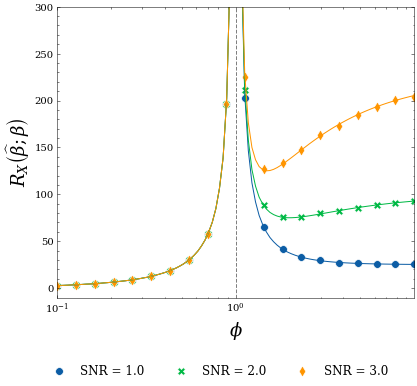

In [8]:
from SRLR import utils
utils.plot_results(files)

# 2. Sketched ridgeless least square estimator with istropic features

###  Orthogonal matrix generation: Subsampled randomized Hadamard transform

There are multiple approaches to generate an orthogonal matrix in Python. One method involves utilizing the ortho_group function from the scipy.stats module. Another faster alternative is to employ the subsampled randomized Hadamard transform algorithm. In this notebook, we provide our own implementation inspired by the work of [Sketching-lr](https://github.com/liusf15/Sketching-lr).

As explained in the manuscript, 
> For orthogonal sketching, we construct an orthogonal sketching matrix based on the subsampled randomized Hadamard transforms. Specifically, we use  $S=BHDP$, where the rows of $B \in \mathbb{R}^{m\times n}$  are sampled  without replacement from the standard basis of  $\mathbb{R}^n$, $H \in \mathbb{R}^{n \times n}$ is a Hadamard matrix, $D \in \mathbb{R}^{n \times n}$ is a diagonal matrix of i.i.d. Rademacher random variables, and $P \in \mathbb{R}^{n \times n}$ is a uniformly distributed permutation matrix. The time complexity of computing $(SX,SY)$ is of order $\mathcal{O}(np\log m )$. Orthogonal sketching matrices can also be realized by, for example, subsampling and Haar distributed matrices.


In [9]:
import numpy as np
np.random.seed(1234)
S = estimators.generate_orthogonal_matrix(400)

def is_orthogonal(matrix):
    product = np.dot(matrix, matrix.T)
    identity = np.eye(matrix.shape[0])
    return np.allclose(product, identity)

is_orthogonal(S)

True

In [10]:
sketched = estimators.SketchedRidgelessRegressor()
m = 100
mse = simulation.simulate(sketched, n_train, n_features, alpha, sigma, seed, n_test, m=m)
print(mse)

89.67567020296345


## Parallel simulation

In [11]:
n_train = 400
n_test = 100
n_features = 200

alpha = 5
sigma = 5
seed = 12341234
n_sim = 5000

n_pts = 20                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 200          # number of points in the graph for visualizing theorem 3.2 (line)

In [ ]:
mse_sketched_emp = simulation.parallel_simulate_psi(ridgeless, n_train, n_features, n_sim, alpha, sigma, seed, n_test, n_pts)
mse_sketched_asy = asymptotics.parallel_asy_psi(n_train, n_features, alpha, sigma, n_pts_asymp, is_orthogonal=True)

In [ ]:
from SRLR import utils
utils.save_results(n_train, n_sim, n_pts, n_pts_asymp, alpha, sigma, seed, mse_emp, mse_asy, fix_phi=False, save_path="../result/thm3.2_fixed_np_S_orthogonal_new/")

In [12]:
files = ['thm3.2_fixed_np_S_orthogonal/SNR1.0_nsim500.json', \
        'thm3.2_fixed_np_S_iid/SNR1.0_nsim500.json'
        ]

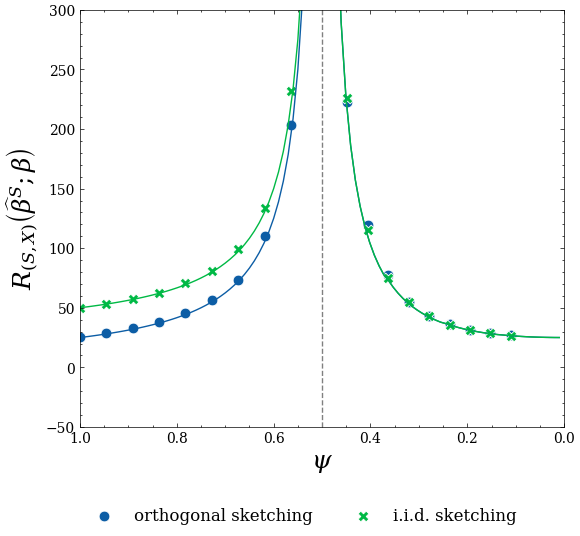

In [13]:
from SRLR import utils
utils.plot_results(files, fix_psi=False)

## Selection of the optimal m for isotropic features
case for SNR < 1

In [14]:
n_train = 400
n_test = 100

alpha = 3
sigma = 4
seed = 12341
n_sim = 500

n_pts = 40                # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 80          # number of points in the graph for visualizing theorem 3.2 (line)

In [ ]:
from SRLR import simulation

sketched = estimators.SketchedRidgelessRegressor()
mse_sketched_emp = simulation.parallel_simulate_phi(sketched, n_train, n_sim, alpha, sigma, seed, n_test, n_pts)

ridgeless = estimators.RidgelessLinearRegressor()
mse_nonsketched_emp = simulation.parallel_simulate_phi(ridgeless, n_train, n_sim, alpha, sigma, seed, n_test, n_pts)

In [ ]:
mse_sketched_asy    = asymptotics.parallel_asy_phi(n_train, alpha, sigma, n_pts, sketching=False)
mse_nonsketched_asy = asymptotics.parallel_asy_phi(n_train, alpha, sigma, n_pts, sketching=True)

In [ ]:
from SRLR import utils
utils.save_results_cmp(n_train, n_sim, n_pts, n_pts_asymp, alpha, sigma, seed, \
                       mse_sketched_emp, mse_sketched_asy, mse_nonsketched_emp, \
                       mse_nonsketched_asy, fix_phi=True, save_path="../result/thm3.6_vary_np_S_orthogonal/")

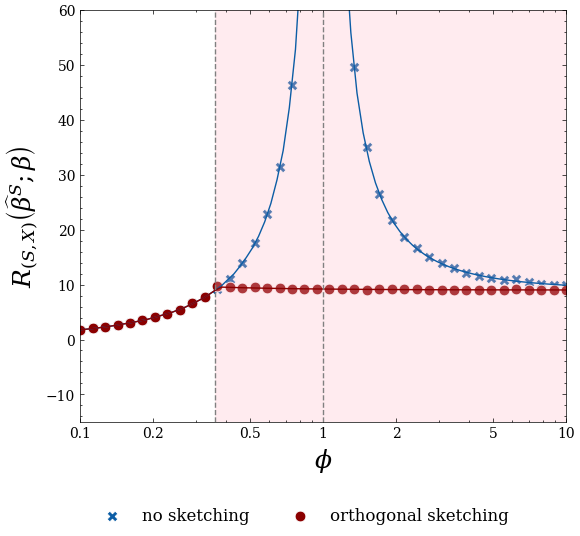

In [16]:
files = ['thm3.6_vary_np_S_orthogonal/alpha3sigma4_nsim500.json']
utils.plot_results_cmp(files, snr=3/4)

case for SNR > 1

In [ ]:
alpha = 6.0
sigma = 2.0

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 120          # number of points in the graph for visualizing theorem 3.2 (line)

from SRLR import simulation

sketched = estimators.SketchedRidgelessRegressor(is_orthogonal=True)
mse_sketched_emp = simulation.parallel_simulate_phi(sketched, n_train, n_sim, alpha, sigma, seed, n_test, n_pts)

ridgeless = estimators.RidgelessLinearRegressor()
mse_nonsketched_emp = simulation.parallel_simulate_phi(ridgeless, n_train, n_sim, alpha, sigma, seed, n_test, n_pts)

mse_sketched_asy    = asymptotics.parallel_asy_phi(n_train, alpha, sigma, n_pts, sketching=False)
mse_nonsketched_asy = asymptotics.parallel_asy_phi(n_train, alpha, sigma, n_pts, sketching=True)

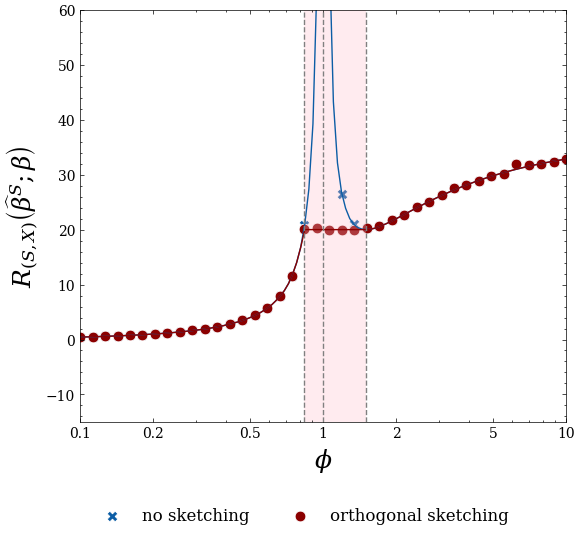

In [18]:
files = ['thm3.6_vary_np_S_orthogonal/alpha6.0sigma2.0_nsim500.json']
utils.plot_results_cmp(files, snr=3)

# 3. Sketched least square estimator with correlated features

## Data generation

- Assumption 2.2, $\beta \sim \mathcal{N}_p\left(0, \frac{\alpha^2}{p} I_p\right)$, where $||\beta||^2_2 \to \alpha^2$, independent of the data matrix $X$, noise $\epsilon$, sketching matrix $S$.
- Assumption $2.4$ (Correlated features). $\Sigma$ is a deterministic positive definite matrix, and there exists constants $C_0, C_1$ satisfying $0<C_0 \leq \lambda_{\min }(\Sigma) \leq \lambda_{\min }(\Sigma) \leq C_1$ for all $n, p$. Define the empirical spectral distribution (ESD) of $\Sigma$ as $F^{\Sigma}(x)=\frac{1}{p} \sum_{i=1}^p \mathbb{1}\left\{\lambda_i(\Sigma) \leq x\right\}$. Assume that as $p \rightarrow \infty$, the ESD $F^{\Sigma}$ converges weakly to a probability measure $H$.


In [19]:
n_train = 400
n_features = 200
n_test = 100

alpha = 9
sigma = 3
seed = 12341
n_sim = 500

n_pts = 20                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 50          # number of points in the graph for visualizing theorem 3.2 (line)

In [20]:
import numpy as np

sketched = estimators.SketchedRidgelessRegressor()
m = 200

lambda_op = list(np.ones(100) * 2) + list(np.ones(100) * 1) 
mse = simulation.simulate(sketched, n_train, n_features, alpha, sigma, seed, n_test, m=m, correlated_features=True, x_sigma=np.diag(lambda_op))
print(mse)

698.2833050328511


In [ ]:
mse_sketched_emp = simulation.parallel_simulate_psi(sketched, n_train, n_features, n_sim, alpha, sigma, seed, n_test, n_pts, correlated_features=True)
mse_sketched_asy = asymptotics.parallel_asy_psi(n_train, n_features, alpha, sigma, n_pts_asymp, is_orthogonal=True, correlated_features=True)

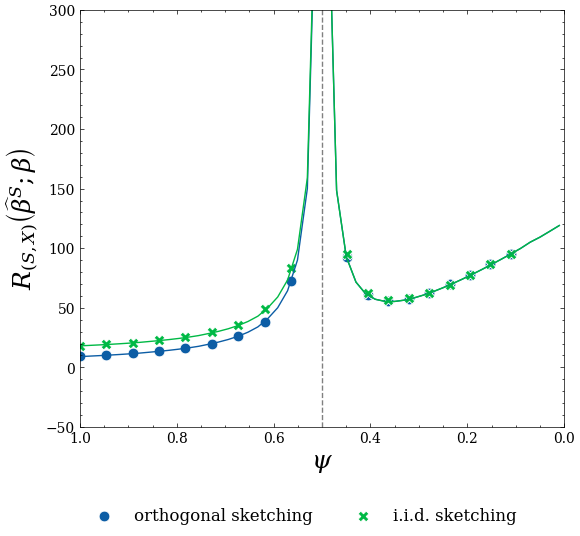

In [21]:
files = ['thm4.2_psi_S_orthogonal/alpha9sigma3_nsim500.json', \
        'thm4.2_psi_S_iid/alpha9sigma3_nsim500.json'
        ]

from SRLR import utils
utils.plot_results(files, fix_psi=False)

## Selection of the optimal m for correlated features

**Finding the unique soltuion of $c_0$**

Lemma 4.1. Under Assumption 2.4, suppose $\phi, \psi>0$ and $\phi \psi^{-1}>1$, then the following equation (4.1) has a unique negative solution with respect to $c_0$,
$$
1=\int \frac{x}{-c_0+x \psi \phi^{-1}} d H(x) .
$$
Throughout this section, we define $c_0=c_0(\phi, \psi, H)$ to be this unique negative solution.

#### Theoretical risk

Theorem 4.2. Suppose Assumptions $2.1,2.2,2.4$ and $2.5$ hold. Suppose also that as $m, n, p \rightarrow \infty, p / n \rightarrow \phi, m / n \rightarrow \psi \in(0,1)$, and $p / m \rightarrow \phi \psi^{-1}>1$. Let $c_0$ be the unique negative solution of (4.1). Then it holds almost surely that for the bias part,
$$
\left.B_{(S, X)} \widehat{\beta^{\mathrm{S}}} ; \beta\right) \rightarrow-\alpha^2 c_0 .
$$
Besides, $\left.B_{(\beta, S, X)} \widehat{\beta^{\mathrm{S}}} ; \beta\right)$ converges almost surely to the same limit. For the variance part,
$$
V_{(\beta, S, X)}\left(\widehat{\beta}^S ; \beta\right)=V_{(S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right) \rightarrow \sigma^2 \frac{\int \frac{x^2 \psi \phi^{-1}}{\left(c_0-x \psi \phi^{-1}\right)^2} d H(x)}{1-\int \frac{x^2 \psi \phi^{-1}}{\left(c_0-x \psi \phi^{-1}\right)^2} d H(x)} .
$$
The out-of-sample prediction risks $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$ and $R_{(\beta, S, X)}\left(\widehat{\beta}^S ; \beta\right)$ converges almost surely to the corresponding sum.

Theorem 4.3. Suppose Assumptions 2.1, 2.2, $2.4$ and $2.5$ hold. Suppose also that as $m, n, p \rightarrow \infty, p / n \rightarrow \phi, m / n \rightarrow \psi \in(0,1)$, and $p / m \rightarrow \phi \psi^{-1}<1$. Then for the bias part, it holds almost surely that
Define $\widetilde{c}_0=\widetilde{c}_0(\phi, \psi, B)$ be the unique negative solution of the following equation,
$$
1=\psi \int \frac{x}{-\widetilde{c}_0+x \phi} d B(x) .
$$
Then for the variance part, it holds almost surely that

$$
V_{(S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right)=V_{(\beta, S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right) \rightarrow \sigma^2 \frac{\psi \int \frac{x^2 \phi}{\left(\widetilde{c}_0-x \phi\right)^2} d B(x)}{1-\psi \int \frac{x^2 \phi}{\left(c_0-x \phi\right)^2} d B(x)}
$$

In [22]:
n_train = 400
n_test = 100

alpha = 6
sigma = 3.0
seed = 12341
n_sim = 500

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 80           # number of points in the graph for visualizing theorem 3.2 (line)

In [ ]:
sketched = estimators.SketchedRidgelessRegressor()
mse_nonsketched_emp = simulation.parallel_simulate_phi(sketched, n_train, n_sim, alpha, sigma, seed, n_test, n_pts, correlated_features=True)
mse_nonsketched_asy = asymptotics.parallel_asy_phi(n_train, alpha, sigma, n_pts_asymp, sketching=False, correlated_features=True)

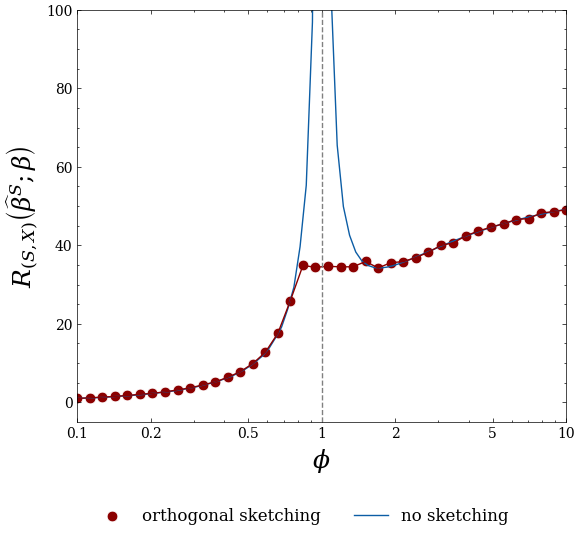

In [23]:
files = ['thm4.2_sym_lambda_S_orthogonal/snr2.0.json']
utils.plot_results_cmp(files, correlated=True)

# 4. Practical procedure to select the sketching size

In [24]:
n_train = 400
n_test = 100
n_val = 100

n_psi = 20

alpha = 6
sigma = 3.0
seed = 12341
n_sim = 500

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 80           # number of points in the graph for visualizing theorem 3.2 (line)

Isotropic features case:

In [ ]:
sketched = estimators.SketchedRidgelessRegressor()
simulation.parallel_simulate_emp_m(sketched, n_train, n_sim, alpha, sigma, seed, n_test, n_pts, n_psi, n_val, correlated_features=False)

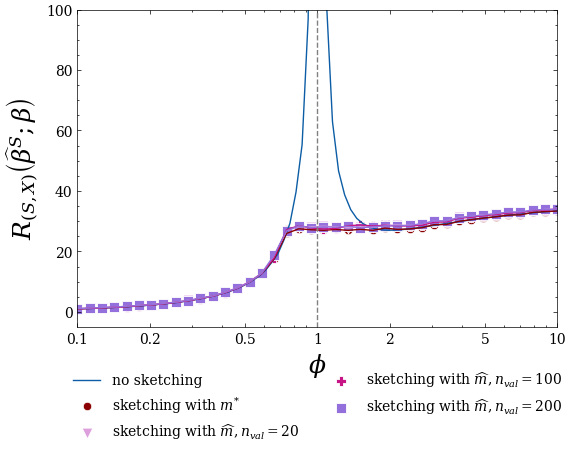

In [25]:
file_base = ['indep_practical_procedure/snr2.0_optimal_m.json']
file_emp = ['indep_practical_procedure/snr2.0_20.json',
            'indep_practical_procedure/snr2.0_100.json',
            'indep_practical_procedure/snr2.0_200.json']
utils.plot_results_emp_m(file_base, file_emp)

Correlated features case:

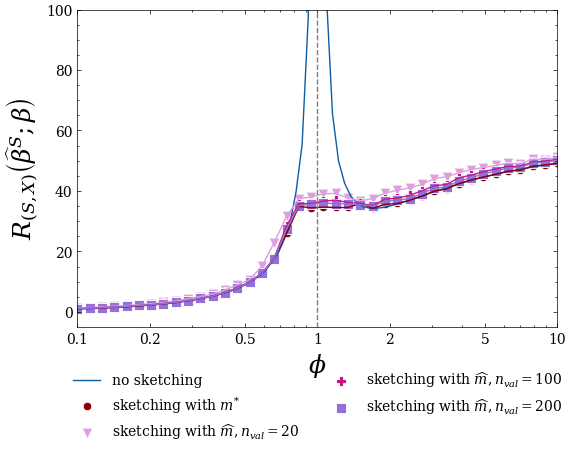

In [26]:
file_base = ['thm4.2_sym_lambda_S_orthogonal/snr2.0.json']
file_emp = ['practical_procedure/snr2.0_20.json',
            'practical_procedure/snr2.0_100.json',
            'practical_procedure/snr2.0_200.json']
utils.plot_results_emp_m(file_base, file_emp)